# Chapter 5 - Machine Learning with Scikit-learn 

In [156]:
%pip install kaggle ipykernel pandas 

Note: you may need to restart the kernel to use updated packages.


### Importing CSV, Excel, and Other File Formats

In [157]:
import pandas as pd
# Load a CSV file
df = pd.read_csv('datasets/building_energy_consumption.csv')

You can use the code below in case your datasets is in json or parquet format, also a sqllite example is provided. Uncomment and run

In [158]:
# Load a JSON file
#df = pd.read_json('path/to/your/file.json')
	
# Load a Parquet file
#df = pd.read_parquet('path/to/your/file.parquet')

# Load data from a SQL database
#import sqlite3

#conn = sqlite3.connect('path/to/your/database.db')
#df = pd.read_sql_query('SELECT * FROM table_name', conn)


### Data preparation and processing

In [159]:
import pandas as pd

# Load the dataset
df = pd.read_csv('datasets/building_energy_consumption.csv')
print("Initial dataset shape:", df.shape)
print(df.head())

Initial dataset shape: (48, 5)
         date building_type  temperature  occupancy  energy_consumption
0  2023-01-01   Residential        21.23      745.0             1091.46
1  2023-01-02    Commercial        16.78      625.0             1762.85
2  2023-01-03    Industrial        33.45      308.0             1735.28
3  2023-01-04    Industrial        25.37      178.0            10000.00
4  2023-01-05   Residential        22.50      210.0             3242.05


In [160]:
initial_shape = df.shape
print(df.head())
df.dropna(inplace=True)
print("Rows with missing values removed:", initial_shape[0] - df.shape[0])
print("Current dataset shape:", df.shape)


         date building_type  temperature  occupancy  energy_consumption
0  2023-01-01   Residential        21.23      745.0             1091.46
1  2023-01-02    Commercial        16.78      625.0             1762.85
2  2023-01-03    Industrial        33.45      308.0             1735.28
3  2023-01-04    Industrial        25.37      178.0            10000.00
4  2023-01-05   Residential        22.50      210.0             3242.05
Rows with missing values removed: 3
Current dataset shape: (45, 5)


In [161]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
missing_before = df['energy_consumption'].isnull().sum()
df['energy_consumption'] = imputer.fit_transform(df[['energy_consumption']])
missing_after = df['energy_consumption'].isnull().sum()
print("Rows with missing values in 'energy_consumption' before imputation:", missing_before)
print("Rows with missing values in 'energy_consumption' after imputation:", missing_after)


Rows with missing values in 'energy_consumption' before imputation: 0
Rows with missing values in 'energy_consumption' after imputation: 0


In [162]:
from scipy import stats
import numpy as np

z_scores = np.abs(stats.zscore(df['energy_consumption']))
outliers = df[z_scores > 3]
print("Identified outliers:\n", outliers)

Identified outliers:
           date building_type  temperature  occupancy  energy_consumption
47  2023-02-17    Commercial        31.45      734.0            28247.33


In [163]:
df = df[z_scores < 3]
print("Rows after removing outliers:", df.shape[0])


Rows after removing outliers: 44


In [164]:
# Show summary of outliers before transformation
upper_limit_before = df['energy_consumption'].quantile(0.95)
lower_limit_before = df['energy_consumption'].quantile(0.05)
outliers_before = df[(df['energy_consumption'] > upper_limit_before) | (df['energy_consumption'] < lower_limit_before)]
print(f"Number of outliers before transformation: {len(outliers_before)}")
print("Summary statistics of outliers before transformation:")
print(outliers_before['energy_consumption'].describe())
print("Example outlier values before transformation:")
print(outliers_before['energy_consumption'].head(10).to_list())

# Calculate the 95th and 5th percentiles to define upper and lower limits for capping
upper_limit = df['energy_consumption'].quantile(0.95)
lower_limit = df['energy_consumption'].quantile(0.05)

# Cap values above the 95th percentile to the 95th percentile value
# Cap values below the 5th percentile to the 5th percentile value
# This reduces the effect of extreme outliers by bringing them within a reasonable range
# The np.where function is used to conditionally replace values

import numpy as np

df['energy_consumption'] = np.where(df['energy_consumption'] > upper_limit, upper_limit, df['energy_consumption'])
df['energy_consumption'] = np.where(df['energy_consumption'] < lower_limit, lower_limit, df['energy_consumption'])

print("\nTransformed outliers to within 5th and 95th percentiles.")

# Show summary of outliers after transformation (should be zero or very few)
outliers_after = df[(df['energy_consumption'] > upper_limit) | (df['energy_consumption'] < lower_limit)]
print(f"Number of outliers after transformation: {len(outliers_after)}")
if len(outliers_after) > 0:
    print("Summary statistics of outliers after transformation:")
    print(outliers_after['energy_consumption'].describe())
else:
    print("No outliers remain after transformation.")

Number of outliers before transformation: 6
Summary statistics of outliers before transformation:
count        6.000000
mean      9389.348333
std       8880.597660
min       1091.460000
25%       1540.580000
50%       8324.680000
75%      16567.050000
max      20001.550000
Name: energy_consumption, dtype: float64
Example outlier values before transformation:
[1091.46, 15000.0, 1649.36, 1504.32, 20001.55, 17089.4]

Transformed outliers to within 5th and 95th percentiles.
Number of outliers after transformation: 0
No outliers remain after transformation.


# Creating new features

In [165]:
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
print("Created new date features: 'year' and 'month'.")
print(df.head())


Created new date features: 'year' and 'month'.
        date building_type  temperature  occupancy  energy_consumption  year  \
0 2023-01-01   Residential        21.23      745.0            1662.248  2023   
1 2023-01-02    Commercial        16.78      625.0            1762.850  2023   
2 2023-01-03    Industrial        33.45      308.0            1735.280  2023   
3 2023-01-04    Industrial        25.37      178.0           10000.000  2023   
4 2023-01-05   Residential        22.50      210.0            3242.050  2023   

   month  
0      1  
1      1  
2      1  
3      1  
4      1  


In [166]:
df['temperature_energy'] = df['temperature'] * df['energy_consumption']
print("Created new interaction feature: 'temperature_energy'.")

Created new interaction feature: 'temperature_energy'.


In [167]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[['temperature', 'energy_consumption']] = scaler.fit_transform(df[['temperature', 'energy_consumption']])
print("Standardized 'temperature' and 'energy_consumption' features.")
print(df.head())

Standardized 'temperature' and 'energy_consumption' features.
        date building_type  temperature  occupancy  energy_consumption  year  \
0 2023-01-01   Residential    -0.550434      745.0           -0.559080  2023   
1 2023-01-02    Commercial    -1.459929      625.0           -0.527398  2023   
2 2023-01-03    Industrial     1.947098      308.0           -0.536080  2023   
3 2023-01-04    Industrial     0.295702      178.0            2.066721  2023   
4 2023-01-05   Residential    -0.290871      210.0           -0.061554  2023   

   month  temperature_energy  
0      1         35289.52504  
1      1         29580.62300  
2      1         58045.11600  
3      1        253700.00000  
4      1         72946.12500  


In [168]:
from sklearn.preprocessing import MinMaxScaler

normalizer = MinMaxScaler()
df[['temperature', 'energy_consumption']] = normalizer.fit_transform(df[['temperature', 'energy_consumption']])
print("Normalized 'temperature' and 'energy_consumption' features.")
print(df.head())


Normalized 'temperature' and 'energy_consumption' features.
        date building_type  temperature  occupancy  energy_consumption  year  \
0 2023-01-01   Residential     0.333333      745.0            0.000000  2023   
1 2023-01-02    Commercial     0.090562      625.0            0.007992  2023   
2 2023-01-03    Industrial     1.000000      308.0            0.005802  2023   
3 2023-01-04    Industrial     0.559193      178.0            0.662370  2023   
4 2023-01-05   Residential     0.402619      210.0            0.125503  2023   

   month  temperature_energy  
0      1         35289.52504  
1      1         29580.62300  
2      1         58045.11600  
3      1        253700.00000  
4      1         72946.12500  


In [169]:
df = pd.get_dummies(df, columns=['building_type'])
print("Applied one-hot encoding to 'building_type' feature.")
print(df.head())

Applied one-hot encoding to 'building_type' feature.
        date  temperature  occupancy  energy_consumption  year  month  \
0 2023-01-01     0.333333      745.0            0.000000  2023      1   
1 2023-01-02     0.090562      625.0            0.007992  2023      1   
2 2023-01-03     1.000000      308.0            0.005802  2023      1   
3 2023-01-04     0.559193      178.0            0.662370  2023      1   
4 2023-01-05     0.402619      210.0            0.125503  2023      1   

   temperature_energy  building_type_Commercial  building_type_Industrial  \
0         35289.52504                     False                     False   
1         29580.62300                      True                     False   
2         58045.11600                     False                      True   
3        253700.00000                     False                      True   
4         72946.12500                     False                     False   

   building_type_Residential  
0             

In [170]:
#from sklearn.preprocessing import LabelEncoder
#
#le = LabelEncoder()
#df['building_type'] = le.fit_transform(df['building_type'])
#print("Applied label encoding to 'building_type' feature.")
#df

### Train Test Split

In [171]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['energy_consumption'])
y = df['energy_consumption']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Performed train-test split with 80% training and 20% testing data.")

Performed train-test split with 80% training and 20% testing data.


### Cross validation

In [172]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

model = LinearRegression()

# Remove the 'date' column for cross-validation
X_cv = X.drop(columns=['date'])

scores = cross_val_score(model, X_cv, y, cv=5)
print(f'Cross-validation scores: {scores}')
print(f'Mean cross-validation score: {scores.mean()}')

Cross-validation scores: [0.95684324 0.82168077 0.78305162 0.98597417 0.99412282]
Mean cross-validation score: 0.9083345235381396


### Train Test Split    

In [173]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
print("Performed train-test-validation split with 60% training, 20% validation, and 20% testing data.")

Performed train-test-validation split with 60% training, 20% validation, and 20% testing data.


In [174]:
X_train.shape, X_temp.shape, y_train.shape, y_temp.shape

((26, 9), (18, 9), (26,), (18,))

In [175]:
X_val.shape, X_test.shape, y_val.shape, y_test.shape

((9, 9), (9, 9), (9,), (9,))

# Linear Regresion

In [176]:
import pandas as pd

# Load the dataset
url = 'datasets/restaurant_revenue.csv'
df = pd.read_csv(url)

# Display the first few rows of the dataset
df.head()


,Number_of_Customers,Menu_Price,Marketing_Spend,Cuisine_Type,Average_Customer_Spending,Promotions,Reviews,Monthly_Revenue
0,61,43.117635,12.663793,Japanese,36.236133,0,45,350.912040
1,24,40.020077,4.577892,Italian,17.952562,0,36,221.319091
2,81,41.981485,4.652911,Japanese,22.600420,1,91,326.529763
3,70,43.005307,4.416053,Italian,18.984098,1,59,348.190573
4,30,17.456199,3.475052,Italian,12.766143,1,30,185.009121


## Data preparation

In [177]:
# Check for missing values
print(df.isnull().sum())

# Delete missing values 
df.dropna(inplace=True)

# Encode categorical variables
data = pd.get_dummies(df, columns=['Cuisine_Type'], drop_first=True)

# Feature scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features = scaler.fit_transform(data.drop('Monthly_Revenue', axis=1))

# Split the data into features (X) and target (y)
X = pd.DataFrame(scaled_features, columns=data.columns[:-1])
y = data['Monthly_Revenue']

# Train-test-validation split
from sklearn.model_selection import train_test_split

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Number_of_Customers          0
Menu_Price                   0
Marketing_Spend              0
Cuisine_Type                 0
Average_Customer_Spending    0
Promotions                   0
Reviews                      0
Monthly_Revenue              0
dtype: int64
Training set size: 600
Validation set size: 200
Test set size: 200


## Train the model

In [178]:
from sklearn.linear_model import LinearRegression

# Initialize and train the model
model = LinearRegression()
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


## Evaluate the model

In [179]:
from sklearn.metrics import mean_squared_error, r2_score

# Predict on validation set
y_val_pred = model.predict(X_val)

# Calculate metrics
mse_val = mean_squared_error(y_val, y_val_pred)
r2_val = r2_score(y_val, y_val_pred)

print(f"Validation MSE: {mse_val}")
print(f"Validation R2: {r2_val}")

# Predict on test set
y_test_pred = model.predict(X_test)

# Calculate metrics
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"Test MSE: {mse_test}")
print(f"Test R2: {r2_test}")


Validation MSE: 2802.9763800780643
Validation R2: 0.7141719467935193
Test MSE: 3596.3274835159245
Test R2: 0.6707772447786471


/Users/luisvalencia/Documents/PythonPersonalProjects/mmlbook/.venv/lib/python3.13/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/luisvalencia/Documents/PythonPersonalProjects/mmlbook/.venv/lib/python3.13/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/luisvalencia/Documents/PythonPersonalProjects/mmlbook/.venv/lib/python3.13/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_
/Users/luisvalencia/Documents/PythonPersonalProjects/mmlbook/.venv/lib/python3.13/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/luisvalencia/Documents/PythonPersonalProjects/mmlbook/.venv/lib/python3.13/site-packages/sklearn/linear_model/_base.

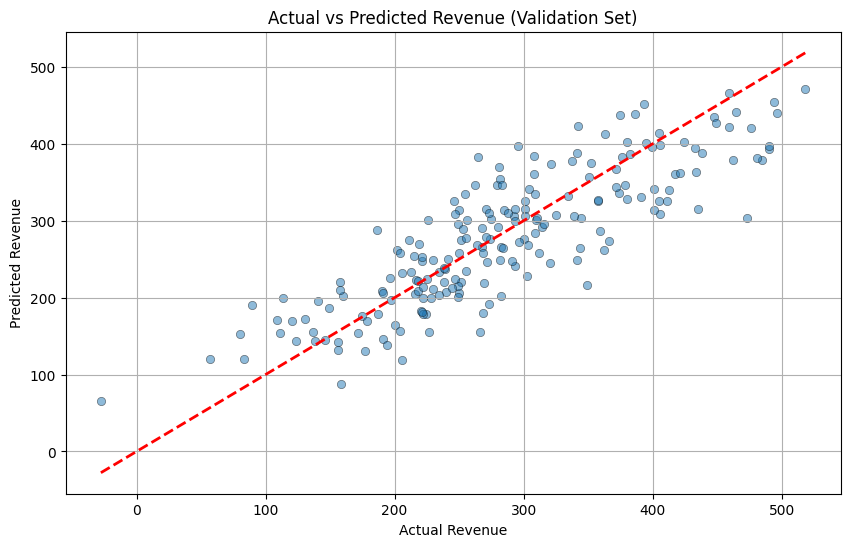

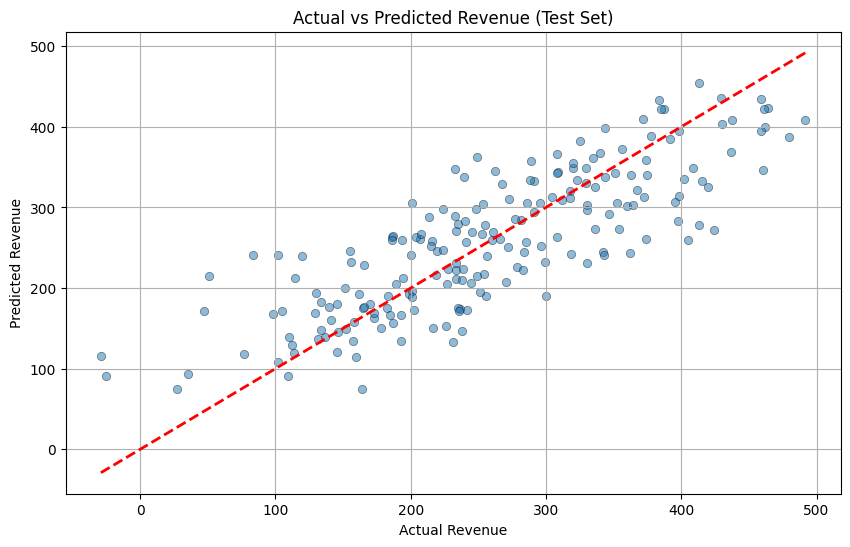

In [180]:
import matplotlib.pyplot as plt

# Function to plot actual vs predicted values
def plot_actual_vs_predicted(y_actual, y_predicted, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_actual, y_predicted, alpha=0.5, edgecolors='k', linewidth=0.5)
    plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'r--', lw=2)
    plt.xlabel('Actual Revenue')
    plt.ylabel('Predicted Revenue')
    plt.title(title)
    plt.grid(True)
    plt.show()

# Plotting the actual vs predicted values for the validation set
plot_actual_vs_predicted(y_val, y_val_pred, 'Actual vs Predicted Revenue (Validation Set)')

# Plotting the actual vs predicted values for the test set
plot_actual_vs_predicted(y_test, y_test_pred, 'Actual vs Predicted Revenue (Test Set)')


## Saving and loading the model

In [181]:
import joblib

# Save the model to disk
joblib.dump(model, 'linear_regression_model.pkl')

# Save the scaler to disk
joblib.dump(scaler, 'scaler.pkl')

# Load the model from disk
loaded_model = joblib.load('linear_regression_model.pkl')

# Load the scaler from disk
loaded_scaler = joblib.load('scaler.pkl')

## Making predictions with new data

In [182]:
# Example new data
new_data = pd.DataFrame({
    'Number_of_Customers': [50, 70, 60],
    'Menu_Price': [40, 45, 55],
    'Marketing_Spend': [10, 15, 12],
    'Cuisine_Type': ['Italian', 'Japanese', 'Mexican'],
    'Average_Customer_Spending': [20, 30, 25],
    'Promotions': [1, 0,1],
    'Reviews': [30, 60, 20]
})

# Preprocessing the new data
#new_data.fillna(method='ffill', inplace=True)
new_data = pd.get_dummies(new_data, columns=['Cuisine_Type'], drop_first=False)

# Ensure new_data has the same columns as the training data
missing_cols = set(X.columns) - set(new_data.columns)
for col in missing_cols:
    new_data[col] = 0
new_data = new_data[X.columns]

# Scale the new data
new_data_scaled = loaded_scaler.fit_transform(new_data)

# Making predictions
new_predictions = loaded_model.predict(new_data_scaled)
print("Predicted Monthly Revenue:", new_predictions)


Predicted Monthly Revenue: [120.48211747 394.02316696 287.4656673 ]


/Users/luisvalencia/Documents/PythonPersonalProjects/mmlbook/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
